In [1]:
import pandas as pd
#df = pd.read_parquet('sources/metadata.parquet', engine='pyarrow')
#df_large = pd.read_parquet('sources/metadata-large.parquet', engine='pyarrow')

exact_matches = pd.read_parquet("../results/artists_exact_match_large.parquet", engine='pyarrow')
assert "artists" in exact_matches.columns, f'artists is not in {exact_matches.columns}'
assert "num_artists" in exact_matches.columns, f'num_artists is not in {exact_matches.columns}'

print(f'exact match shapes {exact_matches.shape}')

# read excel_artist_names
import my_utils

excel_artist_names = my_utils.read_lines_as_list("../sources/excel_artists_copy_paste_name.txt")
hundred_artist_names = excel_artist_names[0:100]
ten_artist_names = excel_artist_names[0:10]


artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')

exact match shapes (1819808, 5)


In [2]:
import wordcloud
from collections import defaultdict
import re

def read_stopwords():
    # from https://gist.github.com/sebleier/554280
    return my_utils.read_lines_as_list("stopwords.txt")

def compute_freq(df, col):
    sw = read_stopwords()
    # print(sw)
    freq = defaultdict(lambda: 0)
    for i, row in df.iterrows():
        string = row[col]
        for s in re.split("[, \-!?:]+", string):
            s=s.strip().lower()
            if s not in sw:
                if len(s)>0:
                    freq[s]=freq[s]+1
    return freq

def compute_wc(freqs, filename, top):
    wc = wordcloud.WordCloud(width = 800, height=400, max_words=top)
    
    wc = wc.generate_from_frequencies(freqs)
    wc.to_file(filename)
    
def remove(freqs, words):
    
    result = defaultdict(lambda: 0)
    for key, value in freqs.items():
        #print(f'key {key}, value {value}')
        if key not in words:
            result[key]=value
    return result
    

In [3]:
top = 40

In [4]:
freqs = compute_freq(exact_matches, "prompt")
freqs = remove(freqs, ["greg", "rutkowski"])
wc = compute_wc(freqs, "testfile.png",top)
print(f'finished')

finished


In [5]:
greg_df = my_utils.exact_match_dataframe(exact_matches, "greg rutkowski")
freqs_greg = compute_freq(greg_df, "prompt")
freqs_greg = remove(freqs_greg, ["greg", "rutkowski"])
compute_wc(freqs_greg, "greg.png", top)
print(f'finished')

finished


In [6]:
#print(freqs)
#print(freqs_greg)

freqs_df = pd.DataFrame.from_dict(freqs, orient="index", columns = ["counts_plain"])
freqs_df.index.name = 'word_plain'

freqs_df.sort_values("counts_plain", axis=0, ascending=False, inplace=True)
#freqs_df['length']=freqs_df.word_plain.apply(lambda x: len(x))
freqs_df.reset_index(inplace=True)
#print(freqs_df.head(20))

freqs_greg_df = pd.DataFrame.from_dict(freqs_greg, orient="index", columns = ["counts_greg"])
freqs_greg_df.index.name = 'word_greg'

freqs_greg_df.sort_values("counts_greg", axis=0, ascending=False, inplace=True)
freqs_greg_df.reset_index(inplace=True)
#print(freqs_greg_df.head(20))

result = pd.concat([freqs_df, freqs_greg_df], axis=1)
print(result.head(20))

      word_plain  counts_plain     word_greg  counts_greg
0            art        640883           art     174496.0
1       detailed        577315      detailed     116662.0
2     artstation        384212    artstation      97624.0
3       painting        369897      painting      86932.0
4       portrait        334497       digital      74957.0
5         highly        274627        highly      74699.0
6       lighting        264449       concept      69337.0
7        digital        254849      portrait      68579.0
8              k        241539       artgerm      66604.0
9      beautiful        233072         sharp      66179.0
10     intricate        222468         focus      63441.0
11      trending        220560     intricate      62426.0
12       concept        214763  illustration      60054.0
13             8        200575         mucha      53139.0
14     cinematic        196355      alphonse      52558.0
15         style        195083       fantasy      45067.0
16         sha

## Plot the words in the rankings

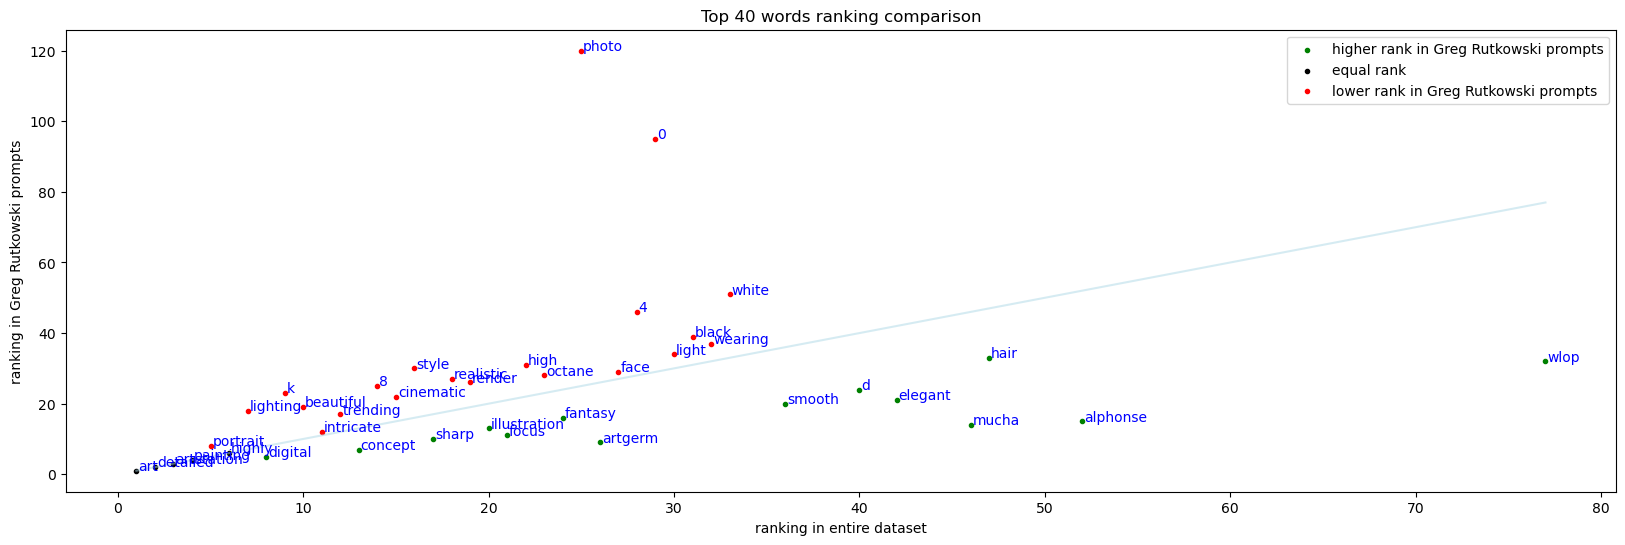

In [20]:

offset = 0.1 # offset for plt plot text
word_amount = 40 # amount of words to plot
words = []
for index, series in result.iterrows():
    if series.word_plain not in words:
        words.append(series.word_plain)
    if series.word_greg not in words:
        words.append(series.word_greg)
    if len(words)>=word_amount:
        break

import matplotlib.pyplot as plt
import matplotlib as mpl
fig, ax1 = plt.subplots(figsize=(20,6))

max_x=0
max_y=0
x_greg, y_greg =[], []
x_plain,y_plain=[], []
x_equal,y_equal=[], []
for w in words:
    x=result.index[result['word_plain'] == w].tolist()[0] + 1
    #print(x)
    y=result.index[result['word_greg'] == w].tolist()[0] + 1
    
    if x>max_x:
        max_x = x
    if y>max_y:
        max_y = y
    if x>y:
        #plt.scatter(x,y,color='green', marker= '.', label="higher rank in Greg Rutkowski prompts")
        x_greg.append(x)
        y_greg.append(y)
    elif x==y:
        #plt.scatter(x,y,color='black', marker= '.', label="equal rank")
        x_equal.append(x)
        y_equal.append(y)
    else:
        #plt.scatter(x,y,color='red', marker= '.', label="lower rank in Greg Rutkowski prompts")
        x_plain.append(x)
        y_plain.append(y)
    plt.text(x+offset, y+offset, f'{w}', horizontalalignment='left', size='medium', color='blue', weight='normal')
    
plt.scatter(x_greg,y_greg,color='green', marker= '.', label="higher rank in Greg Rutkowski prompts")
plt.scatter(x_equal,y_equal,color='black', marker= '.', label="equal rank")
plt.scatter(x_plain,y_plain,color='red', marker= '.', label="lower rank in Greg Rutkowski prompts")
    
t = min(max_x,max_y)
plt.plot([1,t], [1, t], color = 'lightblue', alpha=0.5)
#plt.colorbar(mpl.colormaps["coolwarm"], ax1)
plt.xlabel("ranking in entire dataset")
plt.ylabel("ranking in Greg Rutkowski prompts")
plt.title(f'Top {word_amount} words ranking comparison')
plt.legend()


plt.show()